In [1]:
import datatable as dt
import matplotlib.pyplot as plt
%matplotlib inline

df = dt.fread('winequality-red.csv').to_pandas()

In [2]:
df.isnull().sum().sum()
# The data set is clean

0

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = df.copy(deep=True).values

In [5]:
inputs = torch.from_numpy(data[:, :-1]).type(torch.float)
targets = torch.from_numpy(data[:, -1]).type(torch.float)
targets = torch.reshape(targets, (-1, 1))

In [6]:
from torch.utils.data import TensorDataset, random_split, DataLoader

dataset = TensorDataset(inputs, targets)
train_ratio = 0.8
train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, test_size])

In [7]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32

# Training sampler and data loader
train_loader = DataLoader(train_ds, batch_size, shuffle=True)

val_loader = DataLoader(val_ds, batch_size)

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

input_size = len(df.columns) - 1
output_size = 1


class My_Model(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, xb):
        return self.linear(xb)

    def training_step(self, batch):
        inputs, targets = batch
        # Generate prediction
        y_pred = self(inputs)
        # Calculate loss
        loss = F.mse_loss(y_pred, targets)
        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        # Generate prediction
        y_pred = self(inputs)
        # Calculate loss
        loss = F.mse_loss(y_pred, targets)
        return {'val_loss': loss.detach()}  # Detach = no_grad

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 10% of num_epochs
        if (epoch + 1) % (num_epochs // 10) == 0:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch + 1, result['val_loss']))

In [9]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [10]:
model = My_Model(input_size, output_size)
epochs = 500
lr = 1e-5
history = fit(epochs, lr, model, train_loader, val_loader)

Epoch [50], val_loss: 0.7978
Epoch [100], val_loss: 0.6364
Epoch [150], val_loss: 0.6035
Epoch [200], val_loss: 0.5791
Epoch [250], val_loss: 0.5613
Epoch [300], val_loss: 0.5434
Epoch [350], val_loss: 0.5253
Epoch [400], val_loss: 0.5130
Epoch [450], val_loss: 0.5021
Epoch [500], val_loss: 0.4935


Text(0.5, 1.0, 'Loss vs. No. of epochs')

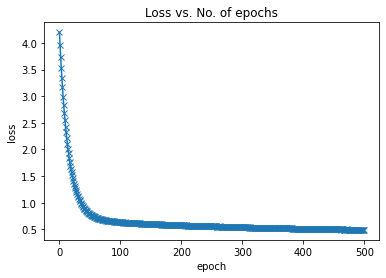

In [11]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

In [12]:
# Make predictions using the trained model
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [17]:
for val_d in val_ds:
    input_, target = val_d
    predict_single(input_, target, model)
    print()

Input: tensor([ 9.9000,  0.4000,  0.5300,  6.7000,  0.0970,  6.0000, 19.0000,  0.9986,
         3.2700,  0.8200, 11.7000])
Target: tensor([7.])
Prediction: tensor([6.8597])

Input: tensor([ 9.9000,  0.6300,  0.2400,  2.4000,  0.0770,  6.0000, 33.0000,  0.9974,
         3.0900,  0.5700,  9.4000])
Target: tensor([5.])
Prediction: tensor([5.1654])

Input: tensor([ 7.9000,  0.6600,  0.0000,  1.4000,  0.0960,  6.0000, 13.0000,  0.9957,
         3.4300,  0.5800,  9.5000])
Target: tensor([5.])
Prediction: tensor([5.1467])

Input: tensor([9.0000e+00, 6.2000e-01, 4.0000e-02, 1.9000e+00, 1.4600e-01, 2.7000e+01,
        9.0000e+01, 9.9840e-01, 3.1600e+00, 7.0000e-01, 9.4000e+00])
Target: tensor([5.])
Prediction: tensor([4.8966])

Input: tensor([ 6.9000,  0.5100,  0.2300,  2.0000,  0.0720, 13.0000, 22.0000,  0.9944,
         3.4000,  0.8400, 11.2000])
Target: tensor([6.])
Prediction: tensor([5.8993])

Input: tensor([ 6.8000,  0.6800,  0.0900,  3.9000,  0.0680, 15.0000, 29.0000,  0.9952,
         3